In [1]:
from pyiron_atomistics import Project
import numpy as np
from typing import Optional

2024-10-31 15:24:58,408 - pyiron_log - WARNING - pyiron found a 'dynamic' folder in the C:/Users/pkruziko/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().
2024-10-31 15:24:58,410 - pyiron_log - WARNING - pyiron found a 'templates' folder in the C:/Users/pkruziko/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().


In [2]:
from pyiron_workflow import Workflow
from pyironflow.pyironflow import PyironFlow

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
@Workflow.wrap.as_function_node
def CreateProject(pr_name:str):
    pr = Project(pr_name)
    
    from ob.concept_dict import export_env
    export_env(pr.path + pr.name)
    
    return pr

In [5]:
@Workflow.wrap.as_function_node
def CreateStructure(pr, structure_name_prefix: str, element:str, bravais_lattice: Optional[str], a: Optional[float|int], c: Optional[float|int] = None, cubic:bool = False):

    import json
    from pyiron_base.storage.hdfio import FileHDFio
    from ob.concept_dict import process_structure_crystal, get_unit_cell_parameters
    
    pr = pr
    if bravais_lattice != 'hcp' and c == None:
        structure = pr.create.structure.bulk(element, crystalstructure=bravais_lattice, cubic=cubic, a=a)
    elif bravais_lattice == 'hcp' and c == None:
        structure = pr.create.structure.bulk(element, crystalstructure=bravais_lattice, cubic=cubic, a=a)
    else:
        structure = pr.create.structure.bulk(element, crystalstructure=bravais_lattice, cubic=cubic, a=a, c=c)

    structure_path = pr.name + '/'
    structure_name = structure_name_prefix + '_input_structure'
    hdf = FileHDFio(structure_path + structure_name + '.h5')
    structure.to_hdf(hdf)

    # Must be conventional unit cell or primitive cell
    # Provide the structure before repetition or any other manipulations
    structure_parameters = get_unit_cell_parameters(structure)
    
    struct_cdict = process_structure_crystal(pr, structure, structure_name, structure_path, structure_parameters)
    
    struct_and_cdict = {'object': structure, 'cdict': struct_cdict}
    
    return struct_and_cdict

In [6]:
@Workflow.wrap.as_function_node("View")
def VisualizeStructure(struct_and_dict):
    return struct_and_dict['object'].plot3d

In [7]:
@Workflow.wrap.as_function_node
def LammpsCalcMinimize(pr, struct_and_cdict, job_name:str, pot_list_index:int, f_tol:float|int, min_style:str, del_ex_job:bool = False, is_child_job = False):
    
    from ob.concept_dict import process_lammps_job
    pr = pr
    structure = struct_and_cdict['object']
    job = pr.create.job.Lammps(job_name=job_name, delete_existing_job=del_ex_job)
    job.structure = structure.copy()
    job.potential = job.list_potentials()[68]
    job.calc_minimize(ionic_force_tolerance=f_tol)

    job_cdict = {} #process_lammps_job(job)

    if is_child_job == False:
        from ob.concept_dict import export_env
        export_env(job.path)
        
        from pyiron_base.storage.hdfio import FileHDFio
        hdf = FileHDFio(job.path + '_input_structure.h5')
        job.structure.to_hdf(hdf)
        job.run()
        # TODO: need to wait for the job to finish! - pr.wait_for_job(job) ?
        job_cdict = process_lammps_job(job)
    
    job_and_cdict = {'object': job, 'cdict': job_cdict}
    
    return job_and_cdict

In [8]:
wf_code = Workflow("test_wf_lammps")

wf_code.CreateProject = CreateProject(pr_name="try1_lammps_Fe")

wf_code.CreateStructure0 = CreateStructure(pr=wf_code.CreateProject, structure_name_prefix="try1_Fe_bcc", element="Fe", 
                                           bravais_lattice="bcc", a=2.845, cubic=True)
wf_code.VisualizeStructure0 = VisualizeStructure(wf_code.CreateStructure0)

wf_code.CreateStructure1 = CreateStructure(pr=wf_code.CreateProject, structure_name_prefix="try1_Fe_fcc", element="Fe", 
                                           bravais_lattice="fcc", a=3.43, cubic=True)
wf_code.VisualizeStructure1 = VisualizeStructure(wf_code.CreateStructure1)

wf_code.CreateStructure2 = CreateStructure(pr=wf_code.CreateProject, structure_name_prefix="try1_Fe_hcp", element="Fe", 
                                           bravais_lattice="hcp", a=2.435)
wf_code.VisualizeStructure2 = VisualizeStructure(wf_code.CreateStructure2)

wf_code.LammpsCalcMinimize0 = LammpsCalcMinimize(pr=wf_code.CreateProject, struct_and_cdict=wf_code.CreateStructure0,
                                                job_name="try1_Fe_bcc", pot_list_index=68, f_tol=1e-8, min_style="fire", del_ex_job=True)
wf_code.LammpsCalcMinimize1 = LammpsCalcMinimize(pr=wf_code.CreateProject, struct_and_cdict=wf_code.CreateStructure1,
                                                job_name="try1_Fe_fcc", pot_list_index=68, f_tol=1e-8, min_style="fire", del_ex_job=True)
wf_code.LammpsCalcMinimize2 = LammpsCalcMinimize(pr=wf_code.CreateProject, struct_and_cdict=wf_code.CreateStructure2,
                                                job_name="try1_Fe_hcp", pot_list_index=68, f_tol=1e-8, min_style="fire", del_ex_job=True)

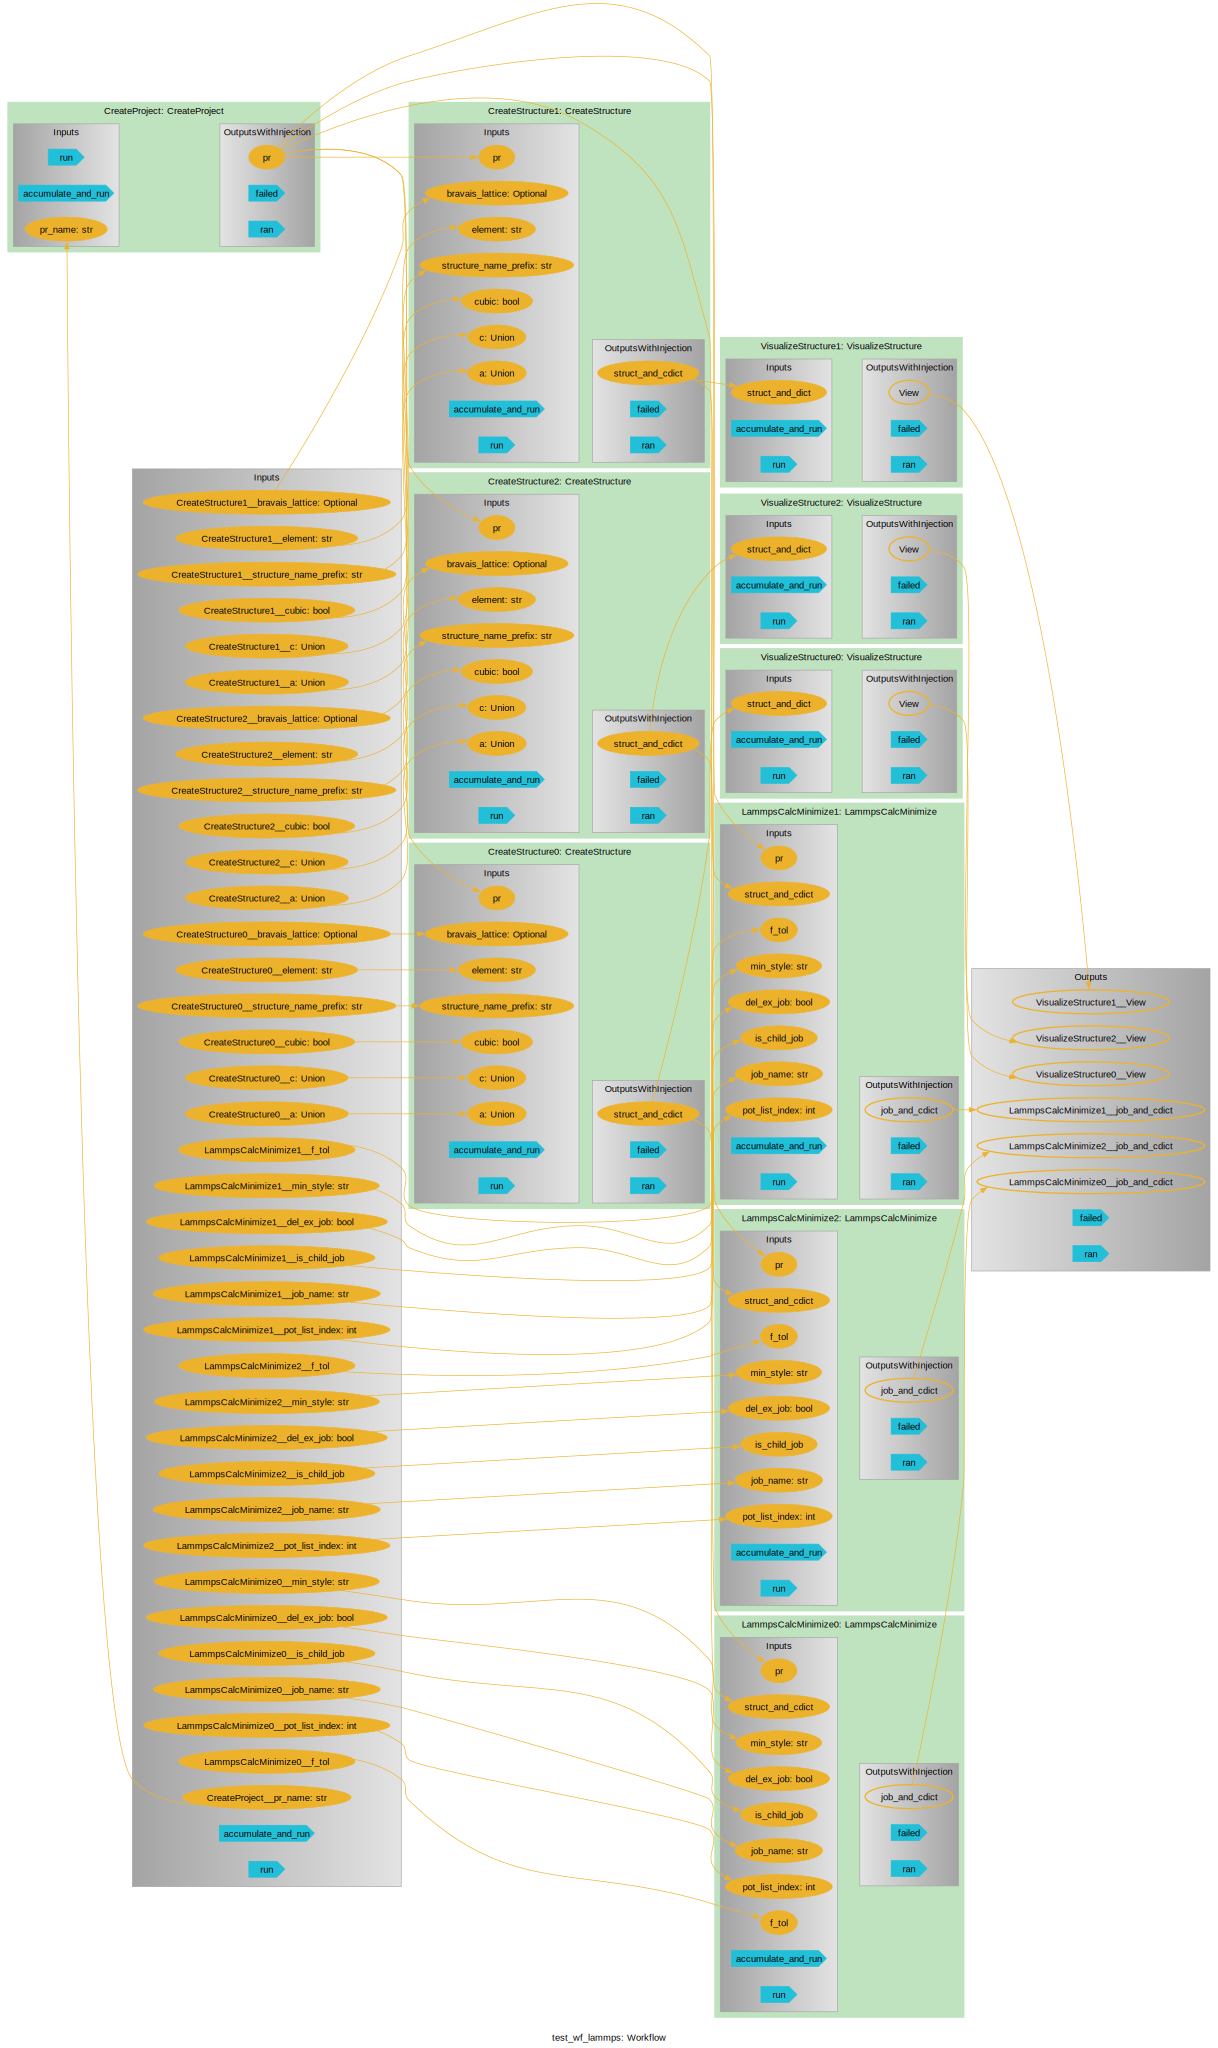

In [9]:
wf_code.draw(size=(30,30), depth=2)

In [10]:
_ = wf_code()

The job try1_Fe_hcp was saved and received the ID: 208
The job try1_Fe_fcc was saved and received the ID: 209
The job try1_Fe_bcc was saved and received the ID: 210


In [11]:
from ob.openbis import openbis_login
o = openbis_login("https://test3.datastore.bam.de/", "pkruziko")

Enter openBIS password:  ········


In [12]:
o.get_session_info().userName

'pkruziko'

In [13]:
from ob.openbis import flatten_cdict, GenericCrystalObject, GenericLammpsJobObject
ob_structure0 = GenericCrystalObject(o, 'PKRUZIKO', 'TEST', 'TEST_WF_LAMMPS', wf_code.CreateStructure0.outputs.struct_and_cdict.value['cdict'], show_object=False)
ob_structure1 = GenericCrystalObject(o, 'PKRUZIKO', 'TEST', 'TEST_WF_LAMMPS', wf_code.CreateStructure1.outputs.struct_and_cdict.value['cdict'], show_object=False)
ob_structure2 = GenericCrystalObject(o, 'PKRUZIKO', 'TEST', 'TEST_WF_LAMMPS', wf_code.CreateStructure2.outputs.struct_and_cdict.value['cdict'], show_object=False)
ob_lmp_job0 = GenericLammpsJobObject(o, 'PKRUZIKO', 'TEST', 'TEST_WF_LAMMPS', wf_code.LammpsCalcMinimize0.outputs.job_and_cdict.value['cdict'], show_object=False)
ob_lmp_job1 = GenericLammpsJobObject(o, 'PKRUZIKO', 'TEST', 'TEST_WF_LAMMPS', wf_code.LammpsCalcMinimize1.outputs.job_and_cdict.value['cdict'], show_object=False)
ob_lmp_job2 = GenericLammpsJobObject(o, 'PKRUZIKO', 'TEST', 'TEST_WF_LAMMPS', wf_code.LammpsCalcMinimize2.outputs.job_and_cdict.value['cdict'], show_object=False)
ob_lmp_job0.add_parents([ob_structure0])
ob_lmp_job0.save()
ob_lmp_job1.add_parents([ob_structure1])
ob_lmp_job1.save()
ob_lmp_job2.add_parents([ob_structure2])
ob_lmp_job2.save()


Structure already exists in project! Found structure in: /PKRUZIKO/TEST/MAT_SIM_STR.CRY647


Found structure properties:



property,value,description,type,mandatory
$name,try1_Fe_bcc_input_structure,Name,VARCHAR,True
description,Crystal structure generated using pyiron.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
crystal_orientation,,Miller indices//Millersche Indizes,VARCHAR,False
lattice_param_a_in_a,2.845,Lattice parameter (a) [Å]//Gitterparameter (a) [Å],REAL,False
lattice_param_b_in_a,,Lattice parameter (b) [Å]//Gitterparameter (b) [Å],REAL,False
lattice_param_c_in_a,,Lattice parameter (c) [Å]//Gitterparameter (c) [Å],REAL,False
lattice_c_over_a,,Lattice parameter (c over a)//Gitterparameter (c über a),REAL,False
lattice_angalpha_in_deg,90.0,Lattice angle (alpha) [Degrees]//Gitterwinkel (alpha) [Grad],REAL,False
lattice_angbeta_in_deg,90.0,Lattice angle (beta) [Degrees]//Gitterwinkel (beta) [Grad],REAL,False



Structure already exists in project! Found structure in: /PKRUZIKO/TEST/MAT_SIM_STR.CRY648


Found structure properties:



property,value,description,type,mandatory
$name,try1_Fe_fcc_input_structure,Name,VARCHAR,True
description,Crystal structure generated using pyiron.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
crystal_orientation,,Miller indices//Millersche Indizes,VARCHAR,False
lattice_param_a_in_a,3.43,Lattice parameter (a) [Å]//Gitterparameter (a) [Å],REAL,False
lattice_param_b_in_a,,Lattice parameter (b) [Å]//Gitterparameter (b) [Å],REAL,False
lattice_param_c_in_a,,Lattice parameter (c) [Å]//Gitterparameter (c) [Å],REAL,False
lattice_c_over_a,,Lattice parameter (c over a)//Gitterparameter (c über a),REAL,False
lattice_angalpha_in_deg,90.0,Lattice angle (alpha) [Degrees]//Gitterwinkel (alpha) [Grad],REAL,False
lattice_angbeta_in_deg,90.0,Lattice angle (beta) [Degrees]//Gitterwinkel (beta) [Grad],REAL,False



Structure already exists in project! Found structure in: /PKRUZIKO/TEST/MAT_SIM_STR.CRY649


Found structure properties:



property,value,description,type,mandatory
$name,try1_Fe_hcp_input_structure,Name,VARCHAR,True
description,Crystal structure generated using pyiron.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
crystal_orientation,,Miller indices//Millersche Indizes,VARCHAR,False
lattice_param_a_in_a,2.435,Lattice parameter (a) [Å]//Gitterparameter (a) [Å],REAL,False
lattice_param_b_in_a,,Lattice parameter (b) [Å]//Gitterparameter (b) [Å],REAL,False
lattice_param_c_in_a,3.9763,Lattice parameter (c) [Å]//Gitterparameter (c) [Å],REAL,False
lattice_c_over_a,,Lattice parameter (c over a)//Gitterparameter (c über a),REAL,False
lattice_angalpha_in_deg,90.0,Lattice angle (alpha) [Degrees]//Gitterwinkel (alpha) [Grad],REAL,False
lattice_angbeta_in_deg,90.0,Lattice angle (beta) [Degrees]//Gitterwinkel (beta) [Grad],REAL,False


sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.
sample successfully updated.
sample successfully updated.
sample successfully updated.


In [14]:
pf = PyironFlow([wf_code])
pf.gui

In [15]:
o.logout()